In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from traitlets import validate
import sklearn.model_selection
import numpy as np
import tensorflow as tf
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


In [2]:
data_dir = r"C:\Users\B.BASI REDDY\Documents\TB_Chest_Radiography_Database\Normal"
data_dir2 = r"C:\Users\B.BASI REDDY\Documents\TB_Chest_Radiography_Database\Tuberculosis"

# Load image filenames
img2 = os.listdir(data_dir2)
images = os.listdir(data_dir)

# Create DataFrame
data = pd.DataFrame({
    'image_path': [os.path.join(data_dir, filename) for filename in images] + [os.path.join(data_dir2, filename) for filename in img2],
    'class': ["NORMAL"] * len(images) + ["TUBERCULOSIS"] * len(img2)
})
print("Number of samples in the dataset:", len(data))


Number of samples in the dataset: 80


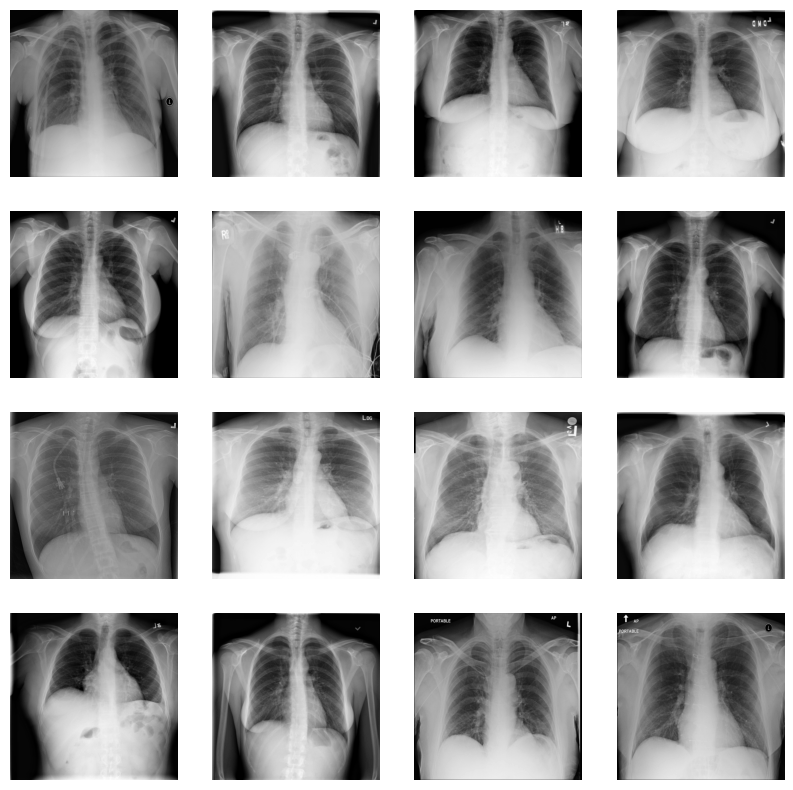

In [3]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axs.ravel()):
    img = cv2.imread(data.iloc[idx]['image_path'], cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()


In [4]:
data = data.sample(frac=1).reset_index(drop=True)

# Split the data into training and validation sets
train_split = 0.8
train_size = int(train_split * len(data))

train_data = data.iloc[:train_size]
validation_data = data.iloc[train_size:]

# Display some information about the data
print("Number of samples in the dataset:", len(data))
print("Number of samples in the training set:", len(train_data))
print("Number of samples in the validation set:", len(validation_data))

# ...

# Set up data generators
batch_size = 32
image_size = (128, 128)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_data,
    x_col='image_path',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)

Number of samples in the dataset: 80
Number of samples in the training set: 64
Number of samples in the validation set: 16
Found 64 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


In [5]:
print("Number of samples in the validation set:", len(validation_generator.filenames))
print("Sample validation file paths:", validation_generator.filenames[:5])

Number of samples in the validation set: 16
Sample validation file paths: ['C:\\Users\\B.BASI REDDY\\Documents\\TB_Chest_Radiography_Database\\Normal\\Normal-37.png', 'C:\\Users\\B.BASI REDDY\\Documents\\TB_Chest_Radiography_Database\\Tuberculosis\\Tuberculosis-21.png', 'C:\\Users\\B.BASI REDDY\\Documents\\TB_Chest_Radiography_Database\\Tuberculosis\\Tuberculosis-33.png', 'C:\\Users\\B.BASI REDDY\\Documents\\TB_Chest_Radiography_Database\\Tuberculosis\\Tuberculosis-3.png', 'C:\\Users\\B.BASI REDDY\\Documents\\TB_Chest_Radiography_Database\\Normal\\Normal-35.png']


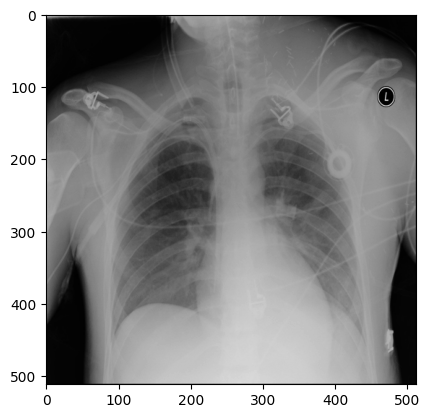

In [6]:
sample_img_path = validation_generator.filepaths[0]
sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_img, cmap='gray')
plt.show()

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator
)

Epoch 1/100
2/2 [==============================] - 4s 1s/step - loss: 0.9343 - accuracy: 0.4688 - val_loss: 0.7152 - val_accuracy: 0.6250
Epoch 2/100
2/2 [==============================] - 2s 1s/step - loss: 0.7415 - accuracy: 0.4688 - val_loss: 0.6725 - val_accuracy: 0.6250
Epoch 3/100
2/2 [==============================] - 2s 937ms/step - loss: 0.6348 - accuracy: 0.6875 - val_loss: 0.6969 - val_accuracy: 0.3750
Epoch 4/100
2/2 [==============================] - 2s 961ms/step - loss: 0.6185 - accuracy: 0.5938 - val_loss: 0.6633 - val_accuracy: 0.6875
Epoch 5/100
2/2 [==============================] - 2s 951ms/step - loss: 0.5733 - accuracy: 0.8438 - val_loss: 0.6298 - val_accuracy: 0.6875
Epoch 6/100
2/2 [==============================] - 2s 946ms/step - loss: 0.5115 - accuracy: 0.8594 - val_loss: 0.6106 - val_accuracy: 0.8125
Epoch 7/100
2/2 [==============================] - 2s 934ms/step - loss: 0.4879 - accuracy: 0.7656 - val_loss: 0.5922 - val_accuracy: 0.7500
Epoch 8/100
2/2 [==

In [9]:
model.save("tbdetection.keras")

In [10]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("tbdetection.keras")

# Evaluate the model on the validation data
accuracy = loaded_model.evaluate(train_generator)[1]
print(f"Accuracy of the loaded model on trained data: {accuracy}")


2/2 [==============================] - 1s 483ms/step - loss: 0.0381 - accuracy: 0.9844
Accuracy of the loaded model on trained data: 0.984375


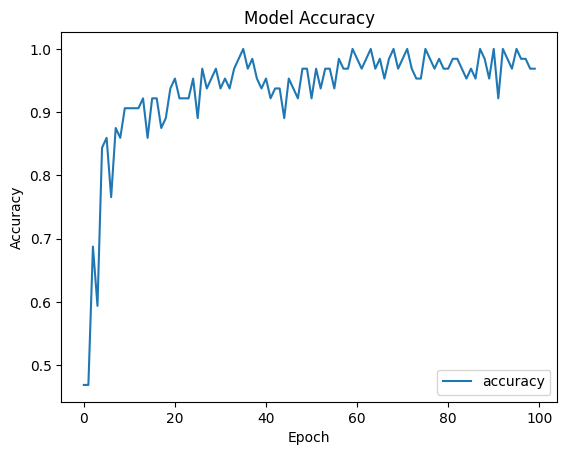

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 62ms/step


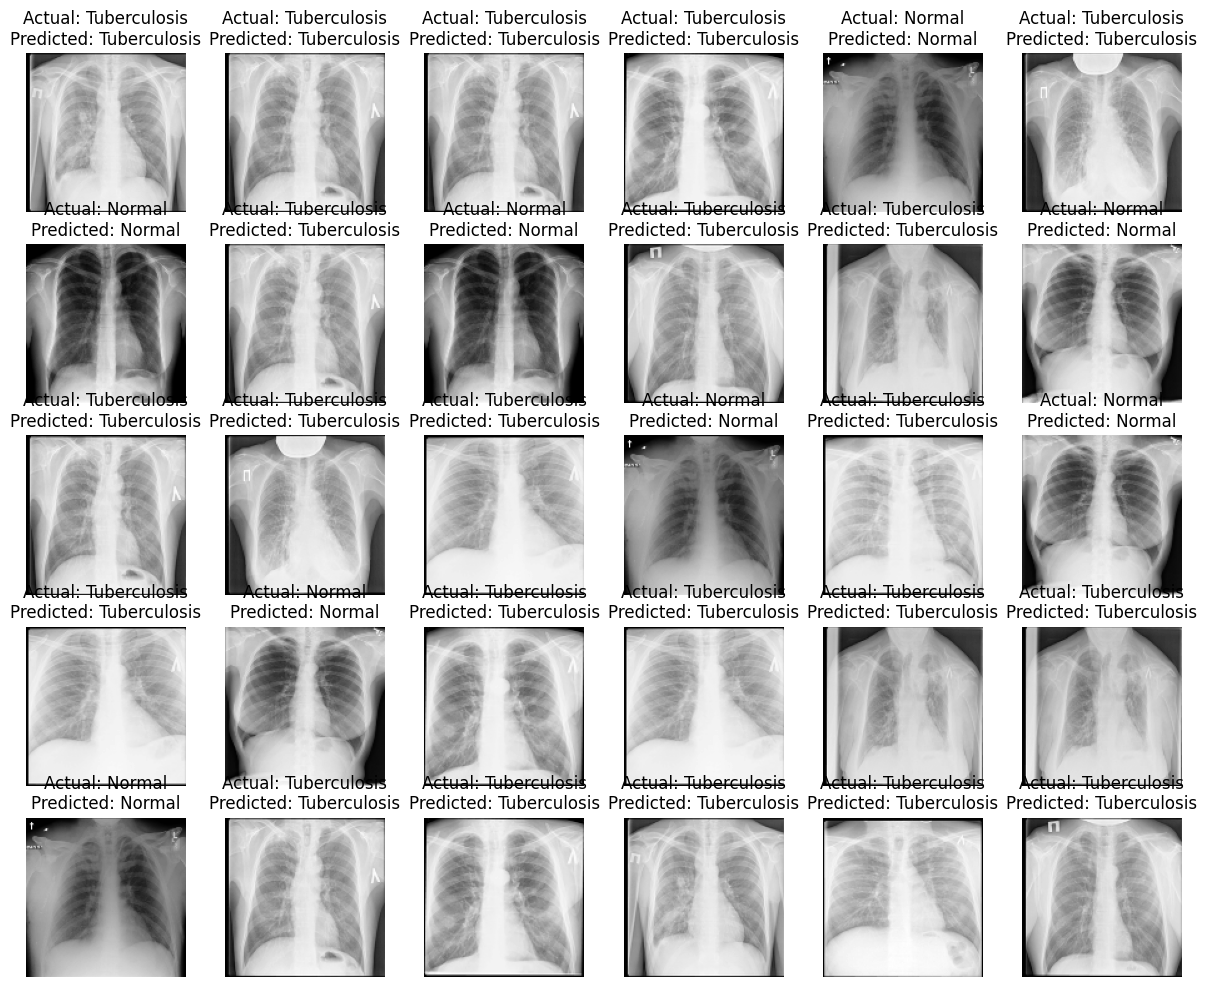

In [28]:
import random as rd

plt.figure(figsize=(15, 12))

# Assuming validation_generator is your validation data generator
for i in range(30):
    random_idx = rd.randint(0, len(validation_data) - 1)
    img_path = validation_data['image_path'].iloc[random_idx]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is not None and img.size > 0:
        img = cv2.resize(img, (128, 128))
        img = np.expand_dims(img, axis=0)
        actual_class = "Tuberculosis" if validation_data['class'].iloc[random_idx] == "TUBERCULOSIS" else "Normal"

        # Load the saved model
        loaded_model = load_model("tbdetection.keras")

        # Predict class probabilities
        class_probabilities = loaded_model.predict(img)

        # Determine the predicted class based on the highest probability
        if class_probabilities[0, 0] > 0.5:
            predicted_class = "Tuberculosis"
        else:
            predicted_class = "Normal"

        plt.subplot(5, 6, i + 1)
        plt.imshow(img[0], cmap='gray')
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
        plt.axis('off')
    else:
        print(f"Image at index {random_idx} could not be loaded.")

plt.show()
